## Task 1-7 

In questo file documentiamo le misure effettuate per valutare il comportamento in frequenza di un filtro passabanda CRRC costituito da due resistenze $R_1 = 100$ $\rm{k\Omega} \pm 5\%$ e $R_2 = 1$ $\rm{k\Omega} \pm 5\%$ e due condensatori $C_1 = 150$ $\rm{nF} \pm 10 \%$ e $C_2 = 68$ $\rm{nF} \pm 10 \%$.

Ci aspettiamo che la funzione di risposta nello spazio delle frequenze abbia la forma $\mathcal{H} = \frac{j\omega\tau_1}{(1+j\omega\tau_1)(1+j\omega\tau_2)+j{\omega}R_{1}C_2} = \frac{j\omega\tau_1}{(1+j\omega\tau_A)(1+j\omega\tau_B)}$, con $\tau_{1,2}=R_{1,2}C_{1,2}$ e $\tau_{A,B}$ correlati alle **frequenze di taglio** del sistema. Otteniamo il grafico fornito nel file `Simulazioni_CRRC.pdf`, in cui confrontiamo la funzione appena scritta, calcolata con Matlab utilizzando i parametri forniti sopra per il circuito, con il risultato della simulazione della risposta a diverse frequenze eseguita nel simulatore numerico di circuiti TINA. 

Eseguiamo il programma di misura, notando prima che funziona come si aspetta a frequenze date, ovvero esibisce uno sfasamento quasi nullo e un guadagno dell'ordine dell'unità a $100$ e $1000$ $\rm{Hz}$ e un guadagno molto più basso a $10$ e $10000$ $\rm{Hz}$. Eseguiamo allora 10000 misure a logaritmi delle frequenze distribuiti in modo uniforme tra $1$ e $10^5$ $\rm{Hz}$ (per semplicità trascuriamo le incertezze sulle frequenze), dei quali il programma fornisce una misura del guadagno. Di default, il programma misura due volte per ogni frequenza. Per ottenere una migliore stima della media e della deviazione standard, decidiamo di modificarlo in modo che per ogni frequenza siano eseguite 10 misure. Eseguiamo poi un fit della funzione fornita sopra, per ottenere stime di $\tau_{A,B}$ (in realtà forniremo $f_{A,B} = \frac{1}{2\pi\tau_{A,B}}$ le **frequenze di taglio** del sistema, alle quali, se $f_A \ll f_B$, il modulo di $\mathcal{H}$ è $1/\sqrt{2}$ del massimo) e di $R_{1,2},C_{1,2}$. Si presenta un problema: i dati raccolti sono relativi ad una variabile dipendente complessa, ovvero due reali, mentre il programma a nostra disposizione per il fit dei minimi quadrati riesce a gestire una sola variabile dipendente reale. Individuiamo due modi per risolvere il problema: la prima è eseguire due fit separati, uno per $|\mathcal{H}|$ e uno per $\rm{arg}(\mathcal{H})$, decidendo poi come gestire le due stime ottenute, oppure scrivere una delle variabili dipendenti come funzione dell'altra. Provate entrambe, osserviamo che nel nostro caso esse danno risultati molto simili, probabilmente perché le componenti a nostra disposizione seguono il modello da noi usato per descriverle molto più precisamente di quanto riusciamo a misurare. Alla fine scegliamo di tenere i dati ottenuti utilizzando solo $|\mathcal{H}|$, prima di tutto perché avere il numero giusto di parametri rende più accurata la valutazione delle incertezze, e secondo perché ci sembra poco giustificato utilizzare 104 parametri per un fit di 100 punti. Di seguito il codice Matlab utilizzato per il fit:

    %Leggiamo i dati misurati tramite Analog Discovery.
    %Essi si trovano disposti in cinque colonne in un file di testo 
    %privo di header

    raw_data = readmatrix("data_err.txt");

    f = raw_data(:,1);
    %La funzione di fit lavora in termini di omega
    omega = f*2*pi;
    G = raw_data(:,2);
    dG = raw_data(:,3);
    phi = raw_data(:,4);
    dphi = raw_data(:,5);


    figure(1);
    plot(f,G,'.');
    xlabel("f [Hz]");
    ylabel("G");
    set(gca,'xscale','log');
    set(gca,'yscale','log');

    figure(2);
    plot(f,phi,'.');
    xlabel("f [Hz]");
    ylabel("phi");
    set(gca,'xscale','log');

    %Utilizziamo il guadagno come variabile dipendente.  
    %In realtà, i parametri del fit indipendenti tra loro sono solamente tre.
    %Utilizzare dunque R1, R2, C1, C2, per quanto utile per confrontarli
    %a posteriori con i parametri del sistema già noti in precedenza,
    %non può costituire una misura di questi quattro parametri.
    %I risultati del fit da considerare significativi sono f_a, f_b e G_max

    function yy = gain(pp, omega)
        R1 = pp(1);
        C1 = pp(2);
        R2 = pp(3);
        C2 = pp(4);
        t1 = R1*C1;
        t2 = R2*C2;
        yy = abs((i*omega*t1./((1+i*omega*t1).*(1+i*omega*t2)+i*omega*R1*C2)));
    end

    function yy = shift(pp, omega)
        R1 = pp(1);
        C1 = pp(2);
        R2 = pp(3);
        C2 = pp(4);
        t1 = R1*C1;
        t2 = R2*C2;
        yy = angle(i*omega*t1./((1+i*omega*t1).*(1+i*omega*t2)+i*omega*R1*C2));
    end

    %Eseguiamo il fit. Stampiamo separatamente i risultati relativi alle
    %resistenze e capacità perché hanno scale diverse

    pp0 = horzcat([1e5, 150e-9, 1e3, 68e-9]);
    [pp,~,~,covb,chi2n] = nlinfit(omega,G,@gain,pp0);
    pp([1 3])
    pp([2 4])
    sigma = sqrt(diag(covb));
    sigma([1 3])
    sigma([2 4])
    chi2n


    figure(1);
    hold on;   
    plot(f,gain(pp, omega),LineWidth=1.5);
    legend("dato","fit",Location="NW");
    hold off;

    figure(2);
    hold on;   
    plot(f,shift(pp, omega),LineWidth=1.5);
    legend("dato","fit",Location="NE");
    hold off;


    function [f_a, f_b] = omegafun(r1, c1, r2, c2)
        t1 = r1*c1;
        t2 = r2*c2;
        omega_a = (1/(2*t1*t2))*(i*(t1+t2+r1*c2)-sqrt(4*t1*t2-(t1+t2+r1*c2)^2));
        omega_b = (1/(2*t1*t2))*(i*(t1+t2+r1*c2)+sqrt(4*t1*t2-(t1+t2+r1*c2)^2));
        t_a = i/omega_a;
        t_b = i/omega_b;
        f_a = 1/(2*pi*t_a);
        f_b = 1/(2*pi*t_b);
    end

    [f_a, f_b] = omegafun(pp(1),pp(2),pp(3),pp(4))

    %Calcoliamo le incertezze su f_a,b tramite una derivata numerica
    df_a = 0;
    df_b = 0;
    for i = (1:4)
        pq = pp;
        pq(i) = pp(i)*(1+1e-9);
        [f_a1, f_b1] = omegafun(pq(1),pq(2),pq(3),pq(4));
        unc1 = 1e9*abs(f_a1-f_a)*sigma(i)/pp(i);
        unc2 = 1e9*abs(f_b1-f_b)*sigma(i)/pp(i);
        df_a = df_a + unc1;
        df_b = df_b + unc2;
    end
    df_a
    df_b

    %Il guadagno massimo è calcolato come tau_1/tau_a
    measured_gain = pp(1)*pp(2)*2*pi*f_a
    sigma_gain = measured_gain*(sigma(1)/pp(1)+sigma(2)/pp(2)+df_a/f_a)

I risultati del fit sono: $f_a = 7.954 \pm 0.004$ $\rm{Hz}$, $f_b = 3397 \pm 2$ $\rm{Hz}$, $G_{max} = 0.6765 \pm 0.0007$.
Per un controllo di sanità, i valori di $R1,R2,C1,C2$ su cui converge il fit, forniti da noi senza incertezza in quanto (come discusso nei commenti del codice), non essendo tutti indipendenti tra loro, questo fit non ne può costituire una misura, sono: $R_1 = 93.4$ $\rm{k\Omega}$, $R_2 = 1.00$ $\rm{k\Omega}$, $C_1 = 145$ $\rm{nF}$, $C_2 = 69.1$ $\rm{nF}$.
Tutte le incertezze, come già detto, sono drasticamente sovrastimate, come dimostra il $\chi^2 \approx 10^{-7}$.
I grafici prodotti sono forniti in `Misura_CRRC.pdf`

# Task 8

Misuriamo un dente di sega di frequenza $f_0 = 10 \,\rm kHz$ con varie frequenze di campionamento ed eseguiamo una FFT sul segnale.

#### $f_s = 1 MSa/s$

In questo caso vale $f_s >> f_0$, quindi la DFT si comporta come vorremmo: abbiamo un primo picco alla frequenza di $f_0 = 10\,\rm kHz$ e picchi decrescenti come $\sim 1/m$ per multipli di $f_0$.

Text(0, 0.5, 'Voltaggio [V]')

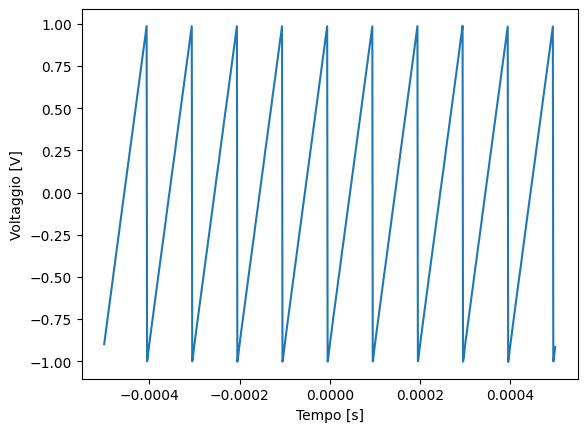

In [1]:
import numpy as np
import matplotlib.pyplot as plt


data = np.loadtxt('triangle1.txt', delimiter='\t', skiprows=3)
plt.plot(data[:,0],data[:,1])
plt.xlabel('Tempo [s]')
plt.ylabel('Voltaggio [V]')

Text(0, 0.5, 'Voltaggio [V]')

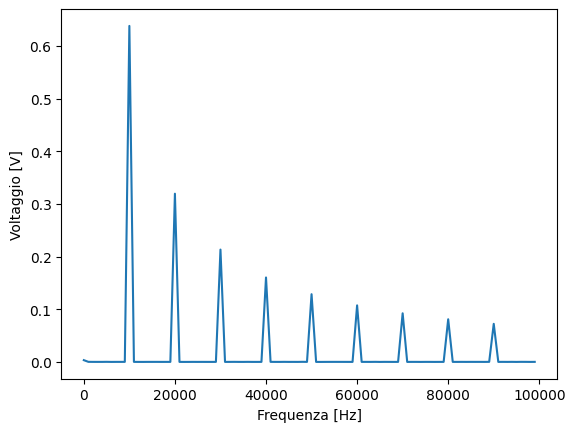

In [2]:
data = np.loadtxt('fourier1.txt', delimiter=',')
plt.plot(data[:100,0],data[:100,1])
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Voltaggio [V]')

#### $f_s = 38 kSa/s$

In questo caso è presente un forte picco alla frequenza corretta di $10 \,\rm kHz$, ma si osservano dei picchi più bassi in tutti i multipli di $2\,\rm kHz$. Questi picchi corrispondono alle frequenze reali di $2 \,\rm kHz + 38 \,\rm kHz = 40\,\rm kHz$, $4 \,\rm kHz + 2*38 \,\rm kHz = 80\,\rm kHz$ etc...

Text(0, 0.5, 'Voltaggio [V]')

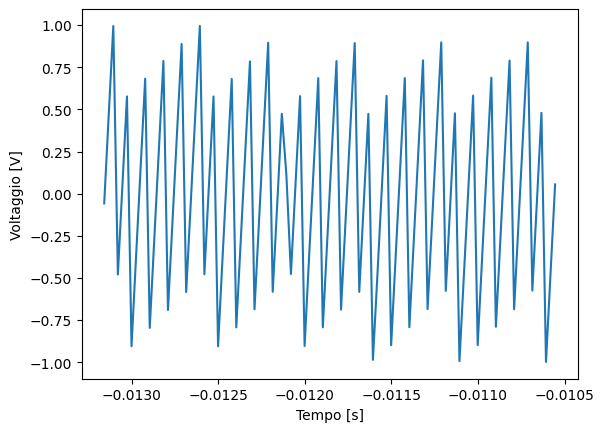

In [3]:
data = np.loadtxt('triangle2.txt', delimiter='\t', skiprows=3)
plt.plot(data[:100,0],data[:100,1])
plt.xlabel('Tempo [s]')
plt.ylabel('Voltaggio [V]')

Text(0, 0.5, 'Voltaggio [V]')

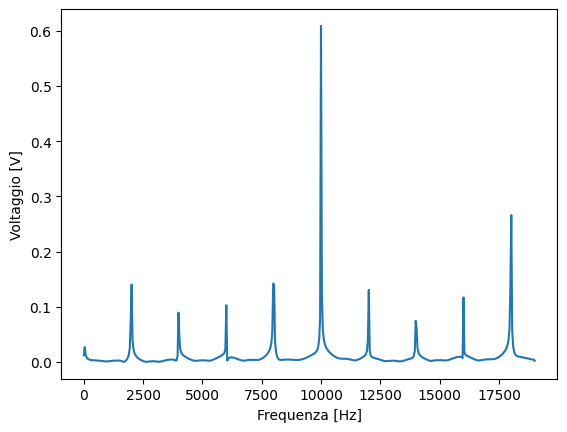

In [4]:
data = np.loadtxt('fourier2.txt', delimiter=',')
plt.plot(data[:,0],data[:,1])
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Voltaggio [V]')

#### $f_s = 10 kSa/s$

In questo caso frequenza del segnale e frequenza di campionamento coincidono, per cui i valori misurati sono pressoché costanti. Quindi, come ci aspettiamo, facendo la DFT troviamo un unico picco a $0 kHz$, come caratteristico di un segnale costante.

Text(0, 0.5, 'Voltaggio [V]')

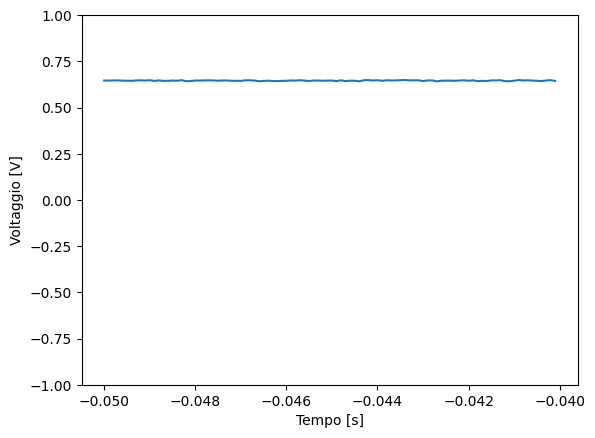

In [5]:
data = np.loadtxt('triangle3.txt', delimiter='\t', skiprows=3)
plt.plot(data[:100,0],data[:100,1])
plt.ylim(-1,1)
plt.xlabel('Tempo [s]')
plt.ylabel('Voltaggio [V]')

Text(0, 0.5, 'Voltaggio [V]')

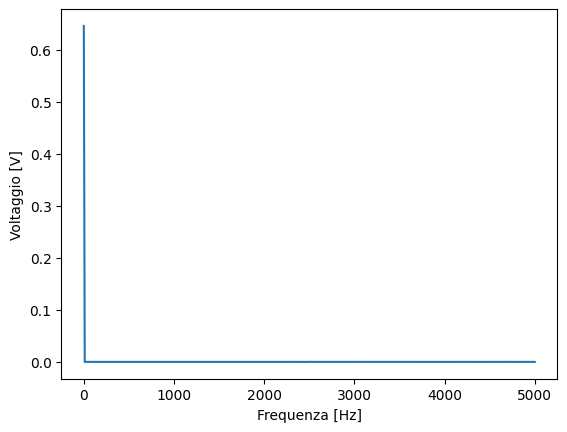

In [6]:
data = np.loadtxt('fourier3.txt', delimiter=',')
plt.plot(data[:,0],data[:,1])
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Voltaggio [V]')

#### $f_s = 10.5 kSa/s$

In questo caso si osserva nuovamente l'aliasing, infatti troviamo picchi nei multipli di $0.5\,\rm kHz$.

Text(0, 0.5, 'Voltaggio [V]')

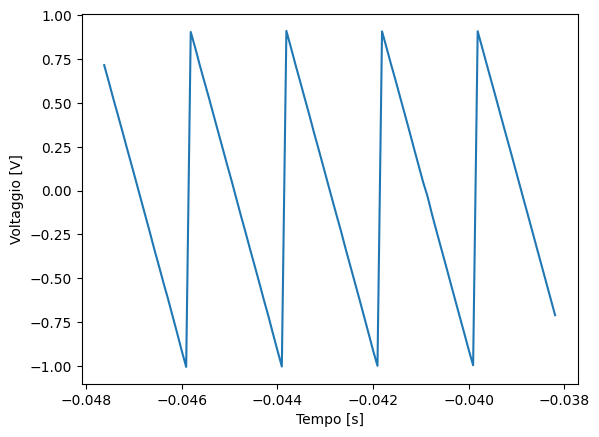

In [7]:
data = np.loadtxt('triangle4.txt', delimiter='\t', skiprows=3)
plt.plot(data[:100,0],data[:100,1])
plt.xlabel('Tempo [s]')
plt.ylabel('Voltaggio [V]')

Text(0, 0.5, 'Voltaggio [V]')

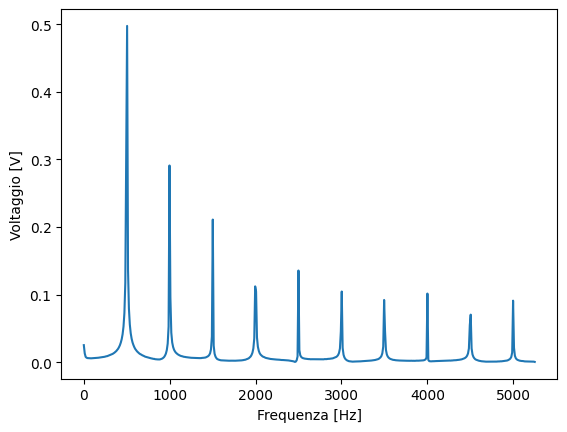

In [8]:
data = np.loadtxt('fourier4.txt', delimiter=',')
plt.plot(data[:,0],data[:,1])
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Voltaggio [V]')

# Task 9

Per apprezzare il leakage, mandiamo come prima un'onda triangolare di frequenza $10 kHz$ e ne campioniamo $1000$ punti.
Usando come frequenza di campionamento $f_s = 1 MHz$ si apprezza come voluto la frequenza fondamentale di $10 kHz$:

Text(0, 0.5, 'Voltaggio [V]')

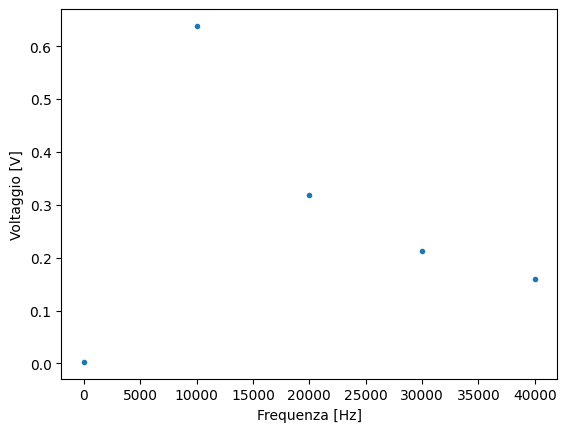

In [9]:
data = np.loadtxt('fourier_leakage1.txt', delimiter=',')
plt.plot(data[:5,0],data[:5,1],'.')
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Voltaggio [V]')

Usando invece una frequenza di campionamento $f_s = 2/3 MHz$ la frequenza fondamentale di $10 kHz$ è sparpagliata fra le frequenze $6.6 kHz$ e $13.3 kHz$.

Text(0, 0.5, 'Voltaggio [V]')

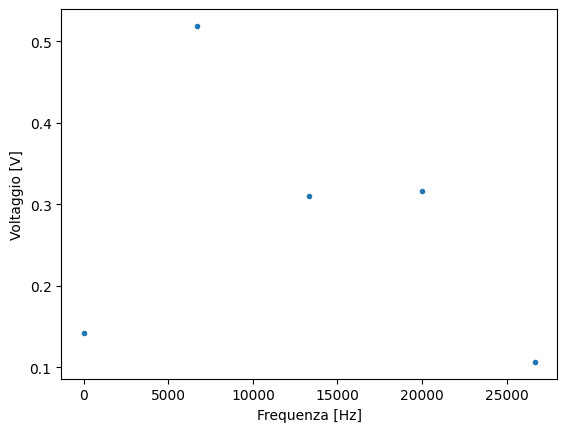

In [10]:
data = np.loadtxt('fourier_leakage2.txt', delimiter=',')
plt.plot(data[:5,0],data[:5,1],'.')
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Voltaggio [V]')

# Task 10

Per approssimare un impulso $\delta (t)$ usiamo una Gaussiana $\delta_a (t) = \frac{1}{a \sqrt{\pi}} e^{-(t/a)^2}$ con il valore $a = 10^{-3}$ ripetuto a una frequenza di $2\,\rm{Hz}$. Campioniamo $10^5$ punti dei segnali in ingresso ed in uscita ad una frequenza $100\,\rm{kHz}$ (quindi due periodi del segnale).

Effettuiamo una DFT sui due segnali, poi eliminando i valori per cui il valore assoluto della trasformata del segnale in ingresso è minore di 2. Dopodiché calcoliamo il guadagno come rapporto delle due trasformate, ottenendo il grafico seguente, che corrisponde al precedente grafico di Bode ma con un forte rumore.

Text(0, 0.5, 'Guadagno')

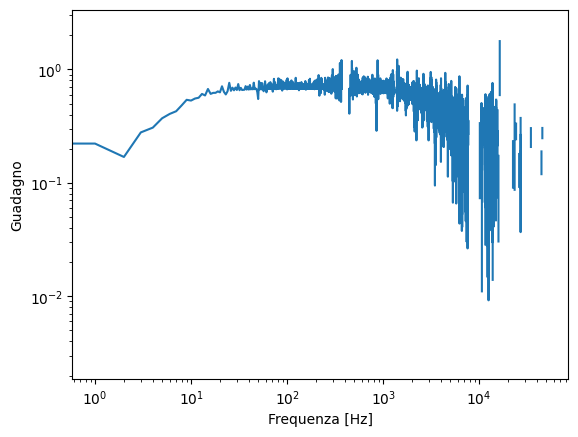

In [11]:
data = np.loadtxt('guadagno_impulso.txt', delimiter=',')
plt.loglog(data[:,0],data[:,1])
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Guadagno')